In [2]:
import pandas as pd
import numpy as np

## Select columns
columns = ['period','source_name', 'source_income', 'destination_name',
           'destination_income', 'cc1 denomination amount',
           'cc1 total cost %', 'cc2 denomination amount', 'cc2 total cost %']

## Rename them
columns_names = ['period','source', 'source_income', 'destination',
           'destination_income', 'cc1 USD amount',
           'cc1 cost %', 'cc2 USD amount', 'cc2 cost %']

## Dataset (up to Q1 2016)
data1 = pd.read_csv('Data/Remittances.xlsx - Dataset (up to Q1 2016).csv')
data1 = data1[columns]
data1.columns = columns_names

## Fix index
data1['period'].replace(['_1Q', '_2Q', '_3Q', '_4Q'], ['-03', '-06', '-09', '-12'], inplace=True, regex=True)
data1['period'] = pd.to_datetime(data1['period'])
data1.set_index('period', inplace=True)

## Dataset (from Q2 2016)
data2 = pd.read_csv('Data/Remittances.xlsx - Dataset (from Q2 2016).csv')
data2 = data2[columns]
data2.columns = columns_names

## Fix index
data2['period'].replace(['_1Q', '_2Q', '_3Q', '_4Q'], ['-03', '-06', '-09', '-12'], inplace=True, regex=True)
data2['period'] = pd.to_datetime(data2['period'])
data2.set_index('period', inplace=True)

raw_data = pd.concat([data1, data2])

/Users/gabrielcontarini/anaconda3/envs/quant/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
periods = raw_data.index.unique()

wb_data = pd.DataFrame()

for i in range(len(periods)):
   wb_data.loc[periods[i], 'cc1 USD amount'] = raw_data[raw_data.index == periods[i]]['cc1 USD amount'].mean()
   wb_data.loc[periods[i], 'cc2 USD amount'] = raw_data[raw_data.index == periods[i]]['cc2 USD amount'].mean()
    
   wb_data.loc[periods[i], 'cc1 cost %'] = raw_data[raw_data.index == periods[i]]['cc1 cost %'].mean()
   wb_data.loc[periods[i], 'cc2 cost %'] = raw_data[raw_data.index == periods[i]]['cc2 cost %'].mean()

In [4]:
## CoinMetrics Data

## Start date
start = '2009-06-10'
##Open data
cm_data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,FeeTotUSD,IssContNtv,SplyCur&start='+start, index_col = 0, parse_dates=True)

In [8]:
## Concat data into df
cm_data.index = cm_data.index.tz_localize(None)
wb_data.index = wb_data.index.tz_localize(None)
df = pd.concat([cm_data, wb_data], axis=1)

df['cc1 cost %'].fillna(method = 'ffill', inplace=True)
df['cc2 cost %'].fillna(method = 'ffill', inplace=True)

In [9]:
## Avoided and BTC Costs

## Cost of 200 USD Remittances by traditional methods 
df['Alt Costs'] = (df['TxTfrValAdjUSD'] * df['cc1 cost %'] / 100)

## Costs on Bitcoin: Miners fees + Exchange Fees
exc_fee = 0.002
df['BTC Costs'] = (df['FeeTotUSD']) + 2 *(df['TxTfrValAdjUSD']* exc_fee)

In [10]:
## Cumulative Avoided Costs
per = 30

## Cumulative Net Avoided Costs
df['c_Avdd Costs'] = (((df['Alt Costs'] - df['BTC Costs'])).rolling(per).mean()).cumsum()
## Cumulative Avoided Costs per Bitcoin
df['c_AC Price'] = df['c_Avdd Costs'] / df['SplyCur']

<ipython-input-11-4543ac3aaf50>:21: RuntimeWarning: invalid value encountered in log
  np.log(df[['e_AC Price', 'PriceUSD']]).plot()


<AxesSubplot:>

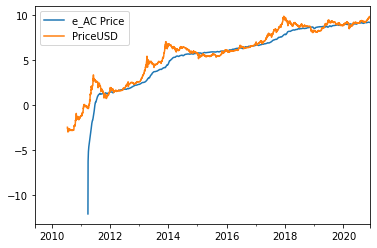

In [11]:
per = 30

## Expected (Past) Net Avoided Costs
df['e_Alt Costs'] = df['Alt Costs'].rolling(window=per).mean().cumsum()
df['e_BTC Costs'] = df['BTC Costs'].rolling(window=per).mean().cumsum()
df['e_avdd costs'] = df['e_Alt Costs'] - df['e_BTC Costs']

## Expected Avdd Costs
df['e_Avdd Costs'] = df['e_avdd costs']

## Expected Volatility Factor
df['BTC Vol Factor'] = (1 + df['PriceUSD'].shift(per).rolling(window=per).std() / df['PriceUSD'].shift(per).rolling(window=per).mean())

## Expected Volume Growth
#df['e_Volume Growth Factor'] = (df['TxTfrValAdjUSD'] / df['TxTfrValAdjUSD'].shift(per)).rolling(per).mean()

## Expected Avoided Costs per Bitcoin
df['e_AC Price'] = df['e_Avdd Costs'] / df['SplyCur'] / df['BTC Vol Factor'] #* df['e_Volume Growth Factor']

#df = df.iloc[720:]
np.log(df[['e_AC Price', 'PriceUSD']]).plot()

#np.log(df['BTC Vol Factor']).plot()


In [12]:
df['e_AC Price'].to_csv('Avoided Costs.csv')